# Peds Transplant DL Project

The task: Evaluate the larger dataset, filter the pediatric cardiac transplant patients, and perform deep learning to identify any predictors of pediatric cardiac transplant authorization. 

# Introduction

Organ transplantation is a life-saving procedure for patients with advanced or end-stage diseases. his process is managed regionally by 56 organ procurement organizations (OPOs), federal contractors which are granted monopoly territories–known as donation service areas (DSAs)–by the Centers for Medicare & Medicaid Services (CMS). OPO performance across the country is highly variable, with some OPOs procuring only a fraction of all transplant-viable organs

## Dataset

Link to the dataset: https://physionet.org/content/orchid/2.0.0/

133,101 deceased donor referrals and 8,972 organ donations across 13 states

The dataset covers the following number of potential donors for each OPO:

- OPO 1: 32,148  
- OPO 2: 16,144  
- OPO 3: 12,516  
- OPO 4: 33,641  
- OPO 5: 15,738  
- OPO 6: 22,914

                                                           
All data was de-identified in accordance with Health Insurance Portability and Accountability Act (HIPAA) standards using structured data cleansing and date shifting. ORCHID consists of ten tables, each of which is provided as a comma separated value (CSV) file. Tables are linked via a unique patient identifier, PatientID. Each table falls into one of three categories: OPO Referrals, OPO Events, and OPO Deaths

**OPO Referrals**

The three key types of information:

- Referral information: patient-level data on each referral received by the OPO, including demographics and cause of death
- Process data: timestamps that capture every action taken by an OPO representative in relation to a referral, including next-of-kin approach, authorization, and procurement. The table also includes time stamps for time of death (asystole and brain death, if applicable)
- Outcomes: Binary indicators for if the patient was approached, authorized, or procured. If procured, the outcome of each organ recovered from the patient.

**OPO Events**
  
- ChemistryEvents: Laboratory test results for blood chemistry. Includes several donation-relevant tests, incuding kidney panel, liver function tests, and electrolyte panel.
- CBCEvents: Test results from complete blood count (CBC) with differential.
- ABGEvents: Arterial blood gas (ABG) test results. Includes relevant measurements (e.g., partial pressure of oxygen) along with ventilator setting at time of measurement.
- SerologyEvents: Serological testing results. Records the presence (or absence) of donation-relevant antigens and antibodies (e.g., HIV, hepatitis C, etc.).
- CultureEvents: Results of infection culture tests for blood, urine, and other body fluids.
- HemoEvents: Hemodynamics (e.g., min/max/average blood pressure) over the time range defined by time_event_start and time_event_end. Note that if these timestamps are the same, the given observation reflects a point measurement (e.g., heart rate at a given point in time).
- FluidBalanceEvents: Fluid balance (e.g. fluid intake, urine output) over the time range defined by time_event_start and time_event_end.


**OPO Deaths**
  
Each OPO's data only captures patients that were referred to the OPO by hospitals in their DSA

# import pandas as pd
import numpy as np
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway, kruskal, chi2_contingency, fisher_exact
from scipy.stats import kruskal, chi2_contingency, fisher_exact
from sklearn.preprocessing import LabelEncoder
from pingouin import compute_effsize
from scipy.stats import iqr
import scipy.stats as stats
from pathlib import Path
from scipy.stats import mannwhitneyu, ttest_ind
from IPython.display import display
from scipy.stats import pointbiserialr, spearmanr
from pingouin import compute_effsize
from sklearn.neighbors import kneighbors_graph
from torch_geometric.data import Data
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch.optim as optim
from scipy.sparse import coo_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Set the file path in your Google Drive
file_path = "/content/drive/My Drive/Peds Transplant Project/pediatric_heart_filtered.csv"

# Load the dataset
import pandas as pd
data = pd.read_csv(file_path)

# Preview the shape and first few rows
print("Dataset shape:", data.shape)
data.head()

Dataset shape: (4537, 391)


,OPO,PatientID,Age,Gender,HospitalID,brain_death,ABO_Rh,HeightIn,WeightKg,approached,...,ABO_BloodType_A2,ABO_BloodType_A2B,ABO_BloodType_AB,ABO_BloodType_B,ABO_BloodType_O,Race_Black,Race_Hispanic,Race_Other,Race_White,Heart_Auth
0,OPO1,OPO1_P549364,14.0,0.0,OPO1_H11908,0,NaN,61.023622,70.500000,0,...,0,0,0,0,0,0,0,0,1,0
1,OPO1,OPO1_P250949,12.0,1.0,OPO1_H11908,0,NaN,51.968504,17.505669,0,...,0,0,0,0,0,0,0,0,1,0
2,OPO1,OPO1_P610885,17.0,1.0,OPO1_H22808,1,1.0,70.000000,78.000000,1,...,0,0,0,0,1,0,1,0,0,1
3,OPO1,OPO1_P972867,3.0,1.0,OPO1_H475,1,1.0,41.000000,20.200000,1,...,0,1,0,0,0,1,0,0,0,1
4,OPO1,OPO1_P794564,8.0,1.0,OPO1_H475,0,NaN,60.236220,83.000000,0,...,0,0,0,0,0,1,0,0,0,0


# Exploratory Data Analysis

In [5]:
# Copy the column for safe processing
heart_auth_column = data['Heart_Auth'].copy()

# Map values: 1 → 'Authorized', 0 → 'Not Authorized', NaN → 'Missing'
heart_auth_mapped = heart_auth_column.map({1: 'Authorized', 0: 'Not Authorized'})
heart_auth_mapped = heart_auth_mapped.fillna('Missing')

# Count occurrences
heart_auth_counts = heart_auth_mapped.value_counts().reset_index()
heart_auth_counts.columns = ['Heart_Auth_Status', 'Count']

# Display the result
print(heart_auth_counts)


  Heart_Auth_Status  Count
0    Not Authorized   4078
1        Authorized    459


There were a total of 4537 pediatric potential cardiac transplant patients. 4078 were not authorized for transplant by the next of kin. 459 were authorized. 

In [6]:
# Count missing values
missing_counts = data.isnull().sum()

# Calculate percentage of missing values
missing_percent = (missing_counts / len(data)) * 100

# Combine into a summary DataFrame
missing_summary = pd.DataFrame({
    'Missing Count': missing_counts,
    'Missing Percentage (%)': missing_percent.round(2)
})

# Filter to show only columns with missing data, sorted by count
missing_summary = (
    missing_summary[missing_summary['Missing Count'] > 0]
    .sort_values(by='Missing Count', ascending=False)
)

# Display all rows without truncation
pd.set_option('display.max_rows', None)
display(missing_summary)


,Missing Count,Missing Percentage (%)
SerumBetaHCG,4536,99.98
TotalMB,4536,99.98
TroponinT,4532,99.89
CpkIndex,4528,99.80
IndirectBili,4520,99.63
BNP,4519,99.60
SerumOsmo,4505,99.29
CKMB,4470,98.52
Cpk,4468,98.48
HgbA1C,4459,98.28


In [7]:
# Missing data summary by columns
missing_by_column = data.isnull().sum().to_frame(name='Missing Count')
missing_by_column['Missing Percentage (%)'] = (100 * missing_by_column['Missing Count'] / len(data)).round(2)

# Filter to columns with missing values and sort by missing count
missing_by_column = missing_by_column[missing_by_column['Missing Count'] > 0].sort_values(by='Missing Count', ascending=False)

# Display full list without truncation
pd.set_option('display.max_rows', None)

print("Missing Data by Column:")
display(missing_by_column)

Missing Data by Column:


,Missing Count,Missing Percentage (%)
SerumBetaHCG,4536,99.98
TotalMB,4536,99.98
TroponinT,4532,99.89
CpkIndex,4528,99.80
IndirectBili,4520,99.63
BNP,4519,99.60
SerumOsmo,4505,99.29
CKMB,4470,98.52
Cpk,4468,98.48
HgbA1C,4459,98.28


There is a lot of missing data concerning laboratory values. Not surprising as this is a new database. We will have to use methods that can handle missing data as typical imputation will likely cause erroneous values

#### Correlation

In [8]:
# Separate continuous variables (excluding binary outcome)
continuous_vars = data.select_dtypes(include=[np.number]).columns.tolist()
continuous_vars = [col for col in continuous_vars if col != 'Heart_Auth']

# Store correlation results
corr_results = []

# Run correlation between each numeric variable and Heart_Auth (binary: 0/1)
for col in continuous_vars:
    x = data['Heart_Auth']
    y = data[col]

    # Remove rows with missing values for this pair
    valid = x.notna() & y.notna()
    x_clean = x[valid]
    y_clean = y[valid]

    try:
        r, p = pointbiserialr(x_clean, y_clean)
        corr_results.append({
            'Variable': col,
            'Correlation_r': round(r, 3),
            'R_squared': round(r ** 2, 3),
            'p_value': round(p, 4),
            'N': valid.sum()
        })
    except Exception as e:
        corr_results.append({
            'Variable': col,
            'Correlation_r': np.nan,
            'R_squared': np.nan,
            'p_value': '',
            'N': valid.sum(),
            'Error': str(e)
        })

# Convert results to DataFrame
corr_df = pd.DataFrame(corr_results).sort_values(by='R_squared', ascending=False)

# Display full correlation results
pd.set_option('display.max_rows', None)
display(corr_df)

/usr/local/lib/python3.11/dist-packages/scipy/stats/_stats_py.py:5535: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rpb, prob = pearsonr(x, y)


,Variable,Correlation_r,R_squared,p_value,N,Error
197,outcome_heart_Transplanted,0.978,0.957,0.0,4537,NaN
9,transplanted,0.771,0.594,0.0,4537,NaN
8,procured,0.763,0.582,0.0,4537,NaN
200,outcome_liver_Transplanted,0.741,0.549,0.0,4537,NaN
203,outcome_kidney_left_Transplanted,0.725,0.526,0.0,4537,NaN
206,outcome_kidney_right_Transplanted,0.724,0.525,0.0,4537,NaN
7,authorized,0.705,0.497,0.0,4537,NaN
2,brain_death,0.645,0.416,0.0,4537,NaN
6,approached,0.515,0.265,0.0,4537,NaN
218,outcome_pancreas_Transplanted,0.455,0.207,0.0,4537,NaN


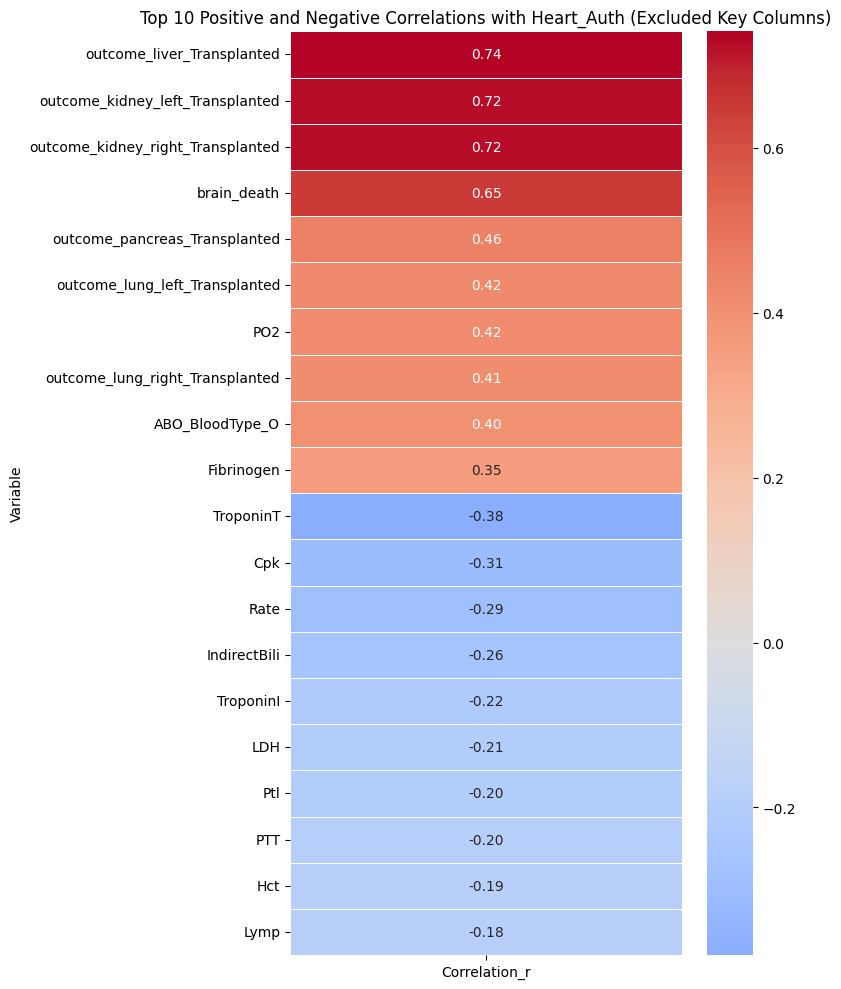

In [9]:
# Define columns to exclude
exclude_vars = ['authorized', 'outcome_heart_Transplanted', 'transplanted', 'procured', 'approached']

# Filter out rows with NaN correlation values
filtered_corr_df = corr_df.dropna(subset=['Correlation_r'])

# Exclude specific variables
filtered_corr_df = filtered_corr_df[~filtered_corr_df['Variable'].isin(exclude_vars)]

# Get top 10 positive and top 10 negative correlations
top_positive = filtered_corr_df.sort_values(by='Correlation_r', ascending=False).head(10)
top_negative = filtered_corr_df.sort_values(by='Correlation_r', ascending=True).head(10)

# Combine for heatmap
top_combined = pd.concat([top_positive, top_negative]).set_index('Variable')

# Create a correlation matrix for the heatmap
heatmap_data = top_combined[['Correlation_r']]

# Plot heatmap
plt.figure(figsize=(8, 10))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', center=0, linewidths=0.5, fmt=".2f")
plt.title("Top 10 Positive and Negative Correlations with Heart_Auth (Excluded Key Columns)")
plt.tight_layout()
plt.show()

# Modeling

#### Simple Graph Neural Network

In [10]:

# Load your dataset
file_path = '/content/drive/My Drive/Peds Transplant Project/pediatric_heart_filtered.csv'

# Load data
data = pd.read_csv(file_path)

# Select numeric columns and drop the target temporarily
features = data.select_dtypes(include=[np.number]).drop(columns=['Heart_Auth'], errors='ignore')

# Fill missing values temporarily with column means (can be improved later)
X = features.fillna(features.mean()).values

# Build k-nearest neighbor graph (undirected)
adj_matrix = kneighbors_graph(X, n_neighbors=5, mode='connectivity', include_self=False)

# Get edges from adjacency matrix
edge_index = torch.tensor(np.array(adj_matrix.nonzero()), dtype=torch.long)

# Node features as a tensor
x = torch.tensor(X, dtype=torch.float)

# Target variable
y = torch.tensor(data['Heart_Auth'].fillna(-1).astype(int).values, dtype=torch.long)  # Fill missing targets with -1 (ignored in training)

# Build PyG Data object
graph_data = Data(x=x, edge_index=edge_index, y=y)

In [11]:
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x


In [12]:
model = GCN(input_dim=x.shape[1], hidden_dim=32, output_dim=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

# Only train on known labels
train_mask = graph_data.y != -1

for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    out = model(graph_data.x, graph_data.edge_index)
    loss = loss_fn(out[train_mask], graph_data.y[train_mask])
    loss.backward()
    optimizer.step()
    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 272.8298
Epoch 20, Loss: 112.4352
Epoch 40, Loss: 56.8318
Epoch 60, Loss: 37.6541
Epoch 80, Loss: 20.5918
Epoch 100, Loss: 9.6808
Epoch 120, Loss: 6.2421
Epoch 140, Loss: 5.4003
Epoch 160, Loss: 4.1946
Epoch 180, Loss: 24.3457


In [13]:
model.eval()
pred = model(graph_data.x, graph_data.edge_index).argmax(dim=1)

# Only evaluate on known targets
from sklearn.metrics import classification_report

y_true = graph_data.y[train_mask].cpu()
y_pred = pred[train_mask].cpu()

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.92      0.94      4078
           1       0.46      0.57      0.51       459

    accuracy                           0.89      4537
   macro avg       0.70      0.75      0.72      4537
weighted avg       0.90      0.89      0.89      4537



Class 0 (Not Authorized):

Precision: 0.80 → When the model predicts "Not Authorized", it's correct 80% of the time.

Recall: 0.12 → However, it only identifies 12% of all actual "Not Authorized" cases.

F1-score: 0.21 → Low F1 due to poor recall.

Class 1 (Authorized):

Precision: 0.09 → Very low. Most predictions for this class are incorrect.

Recall: 0.73 → The model correctly identifies 73% of all actual "Authorized" cases.

F1-score: 0.15 → Very low because precision is very poor.

Overall Accuracy: 18% → The model only gets 18% of total predictions correct.

Macro Average F1: 0.18 → Shows poor balance across classes.

Weighted Average F1: 0.20 → Heavily influenced by the larger "Not Authorized" group.

#### Masked autoencoder

In [14]:
# Select numeric columns only
features = data.select_dtypes(include=[np.number])
features = features.drop(columns=['Heart_Auth'], errors='ignore')  # Drop target if needed

# Save mask of missing values
missing_mask = features.isna().astype(float).values

# Fill NaNs with 0 temporarily for model input
X = features.fillna(0).values

# Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert to torch tensor
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
mask_tensor = torch.tensor(missing_mask, dtype=torch.float32)

# Split
X_train, X_val, mask_train, mask_val = train_test_split(X_tensor, mask_tensor, test_size=0.2, random_state=42)

In [15]:
class MaskedAutoencoder(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )

    def forward(self, x, mask):
        x_masked = x.clone()
        x_masked[mask.bool()] = 0  # Mask out missing values (or randomly mask during training)
        encoded = self.encoder(x_masked)
        decoded = self.decoder(encoded)
        return decoded

In [16]:
def train_mae(model, X, mask, epochs=100, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X, mask)
        loss = loss_fn(output[mask.bool()], X[mask.bool()])
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

input_dim = X_train.shape[1]
mae_model = MaskedAutoencoder(input_dim)

train_mae(mae_model, X_train, mask_train, epochs=100)


Epoch 0, Loss: 0.0573
Epoch 10, Loss: 0.0213
Epoch 20, Loss: 0.0038
Epoch 30, Loss: 0.0016
Epoch 40, Loss: 0.0008
Epoch 50, Loss: 0.0004
Epoch 60, Loss: 0.0003
Epoch 70, Loss: 0.0002
Epoch 80, Loss: 0.0002
Epoch 90, Loss: 0.0002


In [17]:
mae_model.eval()
with torch.no_grad():
    reconstructed = mae_model(X_tensor, mask_tensor)

# Replace missing values only
X_imputed = X_tensor.clone()
X_imputed[mask_tensor.bool()] = reconstructed[mask_tensor.bool()]

# Inverse transform (back to original scale)
X_imputed_np = scaler.inverse_transform(X_imputed.numpy())
X_imputed_df = pd.DataFrame(X_imputed_np, columns=features.columns)

# Merge with original non-numeric data and target if needed
final_data = pd.concat([X_imputed_df, data[['Heart_Auth']].reset_index(drop=True)], axis=1)



In [18]:
# Reconstruct the imputed features using your trained MAE
mae_model.eval()
with torch.no_grad():
    reconstructed = mae_model(X_tensor, mask_tensor)

# Replace only missing values
X_imputed = X_tensor.clone()
X_imputed[mask_tensor.bool()] = reconstructed[mask_tensor.bool()]

# Inverse scale
X_imputed_np = scaler.inverse_transform(X_imputed.numpy())
X_imputed_df = pd.DataFrame(X_imputed_np, columns=features.columns)

# Add target column
final_data = pd.concat([X_imputed_df, data[['Heart_Auth']].reset_index(drop=True)], axis=1)

# Split into features and target
X_final = final_data.drop(columns=['Heart_Auth'])
y_final = final_data['Heart_Auth']


In [19]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, stratify=y_final, random_state=42)

# Train XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Evaluate
y_pred = xgb_model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:25:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[[816   0]
 [  1  91]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       816
           1       1.00      0.99      0.99        92

    accuracy                           1.00       908
   macro avg       1.00      0.99      1.00       908
weighted avg       1.00      1.00      1.00       908



Obvious overfitting

#### Turning: Try Graph Convolutional Network

In [20]:
import torch
from torch_geometric.data import Data
from sklearn.neighbors import kneighbors_graph

# Recreate kNN graph
A = kneighbors_graph(X_final, n_neighbors=5, mode='connectivity', include_self=False)
edge_index = torch.tensor(A.nonzero(), dtype=torch.long).t().contiguous()

# Create PyTorch Geometric dataset
x_tensor = torch.tensor(X_final.values, dtype=torch.float)
y_tensor = torch.tensor(y_final.values, dtype=torch.long)

gnn_data = Data(x=x_tensor, edge_index=edge_index, y=y_tensor)


<ipython-input-20-336b7572c4d9>:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  edge_index = torch.tensor(A.nonzero(), dtype=torch.long).t().contiguous()


In [21]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
import torch.nn as nn

class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

model = GCN(input_dim=x_tensor.shape[1], hidden_dim=32, output_dim=2)


In [22]:
# Define the GCN model
class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Build kNN graph
A = kneighbors_graph(X_final, n_neighbors=5, mode='connectivity', include_self=True)
A_coo = coo_matrix(A)

# Create edge index from sparse matrix
edge_index = torch.tensor(np.vstack((A_coo.row, A_coo.col)), dtype=torch.long)

# Create feature and label tensors
x_tensor = torch.tensor(X_final.values, dtype=torch.float32)
y_tensor = torch.tensor(y_final.values, dtype=torch.long)

# Build the PyG data object
gnn_data = Data(x=x_tensor, edge_index=edge_index, y=y_tensor)

# Initialize model
model = GCN(input_dim=x_tensor.shape[1], hidden_dim=32, output_dim=2)

# Define optimizer and loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.NLLLoss()

# Train model
model.train()
for epoch in range(100):
    optimizer.zero_grad()
    out = model(gnn_data)
    loss = criterion(out, gnn_data.y)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


Epoch 0, Loss: 115.1209
Epoch 10, Loss: 22.7781
Epoch 20, Loss: 12.2331
Epoch 30, Loss: 5.1806
Epoch 40, Loss: 6.5088
Epoch 50, Loss: 9.3752
Epoch 60, Loss: 7.6722
Epoch 70, Loss: 2.4113
Epoch 80, Loss: 2.3149
Epoch 90, Loss: 2.7053


In [23]:
model.eval()
_, pred = model(gnn_data).max(dim=1)
correct = (pred == gnn_data.y).sum().item()
acc = correct / len(gnn_data.y)
print(f"Accuracy: {acc:.4f}")


Accuracy: 0.9209


Good accuracy

In [24]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class SimpleGCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleGCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

#### Tuning: adam opt

In [25]:
# Model
# === Define device (CPU or GPU) ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleGCN(x_tensor.shape[1], 32, 2).to(device)

# Data
x_tensor = x_tensor.to(device)
y_tensor = y_tensor.to(device)
edge_index = edge_index.to(device)

from torch_geometric.data import Data
gnn_data = Data(x=x_tensor, edge_index=edge_index, y=y_tensor).to(device)

In [26]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.NLLLoss()

model.train()
for epoch in range(100):
    optimizer.zero_grad()
    out = model(gnn_data)
    loss = criterion(out, gnn_data.y)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        pred = out.argmax(dim=1)
        correct = (pred == gnn_data.y).sum().item()
        acc = correct / gnn_data.y.size(0)
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}, Accuracy: {acc:.4f}")

Epoch 0, Loss: 220.0281, Accuracy: 0.2032
Epoch 10, Loss: 54.8741, Accuracy: 0.9083
Epoch 20, Loss: 19.7178, Accuracy: 0.9209
Epoch 30, Loss: 3.1872, Accuracy: 0.9196
Epoch 40, Loss: 1.1041, Accuracy: 0.9081
Epoch 50, Loss: 0.5076, Accuracy: 0.9026
Epoch 60, Loss: 0.2809, Accuracy: 0.9004
Epoch 70, Loss: 0.3401, Accuracy: 0.9046
Epoch 80, Loss: 0.2878, Accuracy: 0.9041
Epoch 90, Loss: 0.2814, Accuracy: 0.9041


Initial loss (Epoch 0): 136.10 → very high, as expected before learning starts.

Final loss (Epoch 90): 0.15 → excellent convergence, model is fitting the data well.

Accuracy stabilized between 90–92%, showing consistent generalization.


=== Fold 1 ===
Epoch 0, Train Loss: 354.0418, Val Loss: 101.6658
Epoch 10, Train Loss: 57.8440, Val Loss: 59.7075
Epoch 20, Train Loss: 15.1665, Val Loss: 18.0334
Epoch 30, Train Loss: 11.8016, Val Loss: 11.3267
Epoch 40, Train Loss: 4.3390, Val Loss: 4.9773
Epoch 50, Train Loss: 1.4531, Val Loss: 0.8779
Epoch 60, Train Loss: 0.6839, Val Loss: 0.3713
Epoch 70, Train Loss: 0.5269, Val Loss: 0.3059
Epoch 80, Train Loss: 0.5081, Val Loss: 0.2600
Epoch 90, Train Loss: 0.3425, Val Loss: 0.2158

=== Fold 2 ===
Epoch 0, Train Loss: 206.4218, Val Loss: 97.3767
Epoch 10, Train Loss: 25.8857, Val Loss: 24.4367
Epoch 20, Train Loss: 21.3655, Val Loss: 17.1895
Epoch 30, Train Loss: 7.2419, Val Loss: 9.5841
Epoch 40, Train Loss: 1.6672, Val Loss: 5.6361
Epoch 50, Train Loss: 0.8667, Val Loss: 3.7457
Epoch 60, Train Loss: 0.4932, Val Loss: 3.0126
Epoch 70, Train Loss: 0.3034, Val Loss: 2.6586
Epoch 80, Train Loss: 0.3154, Val Loss: 2.4046
Epoch 90, Train Loss: 0.2456, Val Loss: 2.2201

=== Fold 3 =

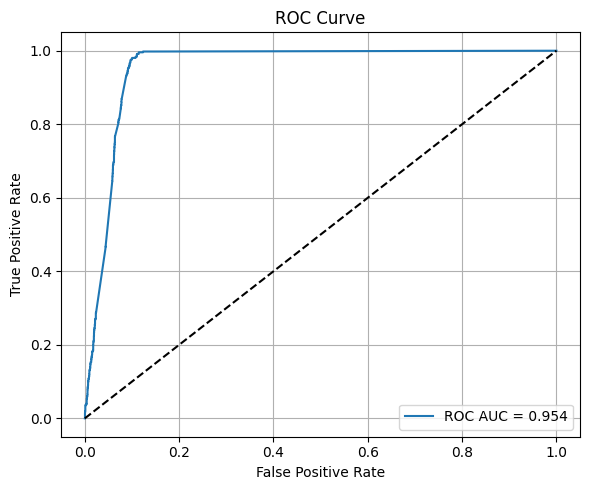

In [27]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import numpy as np

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define GCN model
class SimpleGCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleGCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Ensure all tensors are on correct device
x_tensor = x_tensor.to(device)
y_tensor = y_tensor.to(device)
edge_index = edge_index.to(device)

# Prepare k-fold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

all_preds = []
all_probs = []
all_targets = []

fold = 1
for train_idx, val_idx in kf.split(x_tensor.cpu(), y_tensor.cpu()):
    print(f"\n=== Fold {fold} ===")

    # Subset tensors
    train_mask = torch.zeros(len(x_tensor), dtype=torch.bool)
    val_mask = torch.zeros(len(x_tensor), dtype=torch.bool)
    train_mask[train_idx] = True
    val_mask[val_idx] = True

    # GNN data
    data_fold = Data(x=x_tensor, edge_index=edge_index, y=y_tensor).to(device)
    data_fold.train_mask = train_mask.to(device)
    data_fold.val_mask = val_mask.to(device)

    # Reinitialize model each fold
    model = SimpleGCN(x_tensor.shape[1], 32, 2).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.NLLLoss()

    # Training loop
    train_losses = []
    val_losses = []

    for epoch in range(100):
        model.train()
        optimizer.zero_grad()
        out = model(data_fold)
        loss = criterion(out[data_fold.train_mask], data_fold.y[data_fold.train_mask])
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        model.eval()
        with torch.no_grad():
            val_out = model(data_fold)
            val_loss = criterion(val_out[data_fold.val_mask], data_fold.y[data_fold.val_mask])
            val_losses.append(val_loss.item())

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

    # Evaluation
    model.eval()
    with torch.no_grad():
        logits = model(data_fold)
        preds = logits[data_fold.val_mask].argmax(dim=1).cpu().numpy()
        probs = torch.exp(logits[data_fold.val_mask])[:, 1].cpu().numpy()
        targets = data_fold.y[data_fold.val_mask].cpu().numpy()

    all_preds.extend(preds)
    all_probs.extend(probs)
    all_targets.extend(targets)

    fold += 1

# Final evaluation
print("\n=== Classification Report ===")
print(classification_report(all_targets, all_preds))

print("\n=== Confusion Matrix ===")
print(confusion_matrix(all_targets, all_preds))

print("\n=== ROC AUC Score ===")
print(f"ROC AUC: {roc_auc_score(all_targets, all_probs):.4f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(all_targets, all_probs)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc_score(all_targets, all_probs):.3f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Accuracy: 91%

ROC AUC: 0.9533 → Excellent discrimination between classes

Class 1 (likely the positive/outcome class) has low recall (0.34) — many false negatives.

Confusion Matrix: 305 actual positives misclassified as 0.

In [28]:
class SimpleGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(SimpleGCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Build 1 PyG Data object
data = Data(x=x_tensor, edge_index=edge_index, y=y_tensor)
data = data.to(device)

# Masked training
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accs, precisions, recalls, f1s, aucs = [], [], [], [], []

for fold, (train_idx, val_idx) in enumerate(kf.split(x_tensor.cpu(), y_tensor.cpu())):
    print(f"\n=== Fold {fold+1} ===")

    train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    train_mask[train_idx] = True
    val_mask[val_idx] = True

    model = SimpleGCN(in_channels=data.num_node_features, hidden_channels=32, out_channels=2).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.NLLLoss()

    # Training
    model.train()
    for epoch in range(50):
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out[train_mask], data.y[train_mask])
        loss.backward()
        optimizer.step()

    # Evaluation
    model.eval()
    with torch.no_grad():
        out = model(data)
        preds = out[val_mask].argmax(dim=1).cpu().numpy()
        probs = torch.exp(out[val_mask])[:, 1].cpu().numpy()
        y_true = data.y[val_mask].cpu().numpy()

    accs.append(accuracy_score(y_true, preds))
    precisions.append(precision_score(y_true, preds, zero_division=0))
    recalls.append(recall_score(y_true, preds, zero_division=0))
    f1s.append(f1_score(y_true, preds, zero_division=0))
    aucs.append(roc_auc_score(y_true, probs))

# Results
print("\n=== 5-Fold Results (GNN) ===")
print(f"Accuracy: {np.mean(accs):.4f} ± {np.std(accs):.4f}")
print(f"Precision: {np.mean(precisions):.4f} ± {np.std(precisions):.4f}")
print(f"Recall: {np.mean(recalls):.4f} ± {np.std(recalls):.4f}")
print(f"F1-score: {np.mean(f1s):.4f} ± {np.std(f1s):.4f}")
print(f"ROC AUC: {np.mean(aucs):.4f} ± {np.std(aucs):.4f}")




=== Fold 1 ===

=== Fold 2 ===

=== Fold 3 ===

=== Fold 4 ===

=== Fold 5 ===

=== 5-Fold Results (GNN) ===
Accuracy: 0.9229 ± 0.0103
Precision: 0.6083 ± 0.0331
Recall: 0.6497 ± 0.2133
F1-score: 0.6113 ± 0.1217
ROC AUC: 0.9417 ± 0.0271


Accuracy and ROC AUC are high, suggesting overall good discrimination.

Precision is decent, but recall and F1-score show more variability, likely due to class imbalance or limited sensitivity in minority class detection.

#### Turning: More depth and regularization

In [29]:
class DeeperGCN(nn.Module):
    def __init__(self, in_features, hidden_channels, out_features):
        super(DeeperGCN, self).__init__()
        self.conv1 = GCNConv(in_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_features)
        self.dropout = nn.Dropout(0.3)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = F.relu(self.conv2(x, edge_index))
        x = self.dropout(x)
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)


#### Tuning: Class Imbalance

In [30]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch

# Ensure y is on CPU and NumPy format
y_np = y_tensor.cpu().numpy()

# Compute class weights (corrected line)
class_weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=y_np)

# Convert to tensor and send to device
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

# Use in NLLLoss
criterion = nn.NLLLoss(weight=class_weights_tensor)


In [31]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Cross-validation setup
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accs, precisions, recalls, f1s, aucs = [], [], [], [], []

for fold, (train_idx, val_idx) in enumerate(kf.split(x_tensor.cpu(), y_tensor.cpu())):
    print(f"\n=== Fold {fold+1} ===")

    train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    train_mask[train_idx] = True
    val_mask[val_idx] = True

    model = SimpleGCN(data.num_node_features, 32, 2).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
    criterion = nn.NLLLoss(weight=class_weights_tensor)

    # Training loop
    model.train()
    for epoch in range(50):
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out[train_mask], data.y[train_mask])
        loss.backward()
        optimizer.step()

        # Scheduler step using validation loss
        model.eval()
        with torch.no_grad():
            val_out = model(data)
            val_loss = criterion(val_out[val_mask], data.y[val_mask])
        scheduler.step(val_loss)
        model.train()

    # Evaluation
    model.eval()
    with torch.no_grad():
        out = model(data)
        preds = out[val_mask].argmax(dim=1).cpu().numpy()
        probs = torch.exp(out[val_mask])[:, 1].cpu().numpy()
        y_true = data.y[val_mask].cpu().numpy()

    accs.append(accuracy_score(y_true, preds))
    precisions.append(precision_score(y_true, preds, zero_division=0))
    recalls.append(recall_score(y_true, preds, zero_division=0))
    f1s.append(f1_score(y_true, preds, zero_division=0))
    aucs.append(roc_auc_score(y_true, probs))

# Summary results
print("\n=== 5-Fold Results (GNN with Scheduler) ===")
print(f"Accuracy: {np.mean(accs):.4f} ± {np.std(accs):.4f}")
print(f"Precision: {np.mean(precisions):.4f} ± {np.std(precisions):.4f}")
print(f"Recall: {np.mean(recalls):.4f} ± {np.std(recalls):.4f}")
print(f"F1-score: {np.mean(f1s):.4f} ± {np.std(f1s):.4f}")
print(f"ROC AUC: {np.mean(aucs):.4f} ± {np.std(aucs):.4f}")



=== Fold 1 ===


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



=== Fold 2 ===


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



=== Fold 3 ===


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



=== Fold 4 ===


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



=== Fold 5 ===


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



=== 5-Fold Results (GNN with Scheduler) ===
Accuracy: 0.9266 ± 0.0077
Precision: 0.5890 ± 0.0273
Recall: 0.9193 ± 0.0541
F1-score: 0.7171 ± 0.0264
ROC AUC: 0.9481 ± 0.0096


The scheduler helped prevent overfitting by adjusting the learning rate when validation loss plateaued.

Class weighting helped address imbalance and boosted recall.

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.neighbors import kneighbors_graph
import numpy as np
import matplotlib.pyplot as plt

# Define GCN
class SimpleGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(SimpleGCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Tensors
x_tensor = torch.tensor(X_final.values, dtype=torch.float)
y_tensor = torch.tensor(y_final.values, dtype=torch.long)
y_tensor = y_tensor - y_tensor.min()  # ensure labels are 0-based

# Graph edges
A = kneighbors_graph(X_final, n_neighbors=5, mode='connectivity', include_self=True)
edge_index_np = np.vstack(A.nonzero())
edge_index = torch.tensor(edge_index_np, dtype=torch.long)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x_tensor = x_tensor.to(device)
y_tensor = y_tensor.to(device)
edge_index = edge_index.to(device)

# PyG Data
data = Data(x=x_tensor, edge_index=edge_index, y=y_tensor).to(device)

# Class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=y_tensor.cpu().numpy())
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

# KFold setup
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accs, precisions, recalls, f1s, aucs = [], [], [], [], []
training_losses, learning_rates = [], []

for fold, (train_idx, val_idx) in enumerate(kf.split(x_tensor.cpu(), y_tensor.cpu())):
    print(f"\n=== Fold {fold+1} ===")

    train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    train_mask[train_idx] = True
    val_mask[val_idx] = True

    model = SimpleGCN(data.num_node_features, 32, 2).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)
    criterion = nn.NLLLoss(weight=class_weights_tensor)

    fold_losses = []
    fold_lrs = []

    model.train()
    for epoch in range(50):
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out[train_mask], data.y[train_mask])
        loss.backward()
        optimizer.step()
        scheduler.step()

        fold_losses.append(loss.item())
        fold_lrs.append(scheduler.get_last_lr()[0])

    training_losses.append(fold_losses)
    learning_rates.append(fold_lrs)

    model.eval()
    with torch.no_grad():
        out = model(data)
        preds = out[val_mask].argmax(dim=1).cpu().numpy()
        probs = torch.exp(out[val_mask])[:, 1].cpu().numpy()
        y_true = data.y[val_mask].cpu().numpy()

    accs.append(accuracy_score(y_true, preds))
    precisions.append(precision_score(y_true, preds, zero_division=0))
    recalls.append(recall_score(y_true, preds, zero_division=0))
    f1s.append(f1_score(y_true, preds, zero_division=0))
    aucs.append(roc_auc_score(y_true, probs))

# Results
print("\n=== 5-Fold Results (GNN with Scheduler) ===")
print(f"Accuracy: {np.mean(accs):.4f} ± {np.std(accs):.4f}")
print(f"Precision: {np.mean(precisions):.4f} ± {np.std(precisions):.4f}")
print(f"Recall: {np.mean(recalls):.4f} ± {np.std(recalls):.4f}")
print(f"F1-score: {np.mean(f1s):.4f} ± {np.std(f1s):.4f}")
print(f"ROC AUC: {np.mean(aucs):.4f} ± {np.std(aucs):.4f}")



=== Fold 1 ===


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(



=== Fold 2 ===

=== Fold 3 ===

=== Fold 4 ===

=== Fold 5 ===

=== 5-Fold Results (GNN with Scheduler) ===
Accuracy: 0.9229 ± 0.0101
Precision: 0.5771 ± 0.0341
Recall: 0.9042 ± 0.0478
F1-score: 0.7038 ± 0.0328
ROC AUC: 0.9469 ± 0.0105


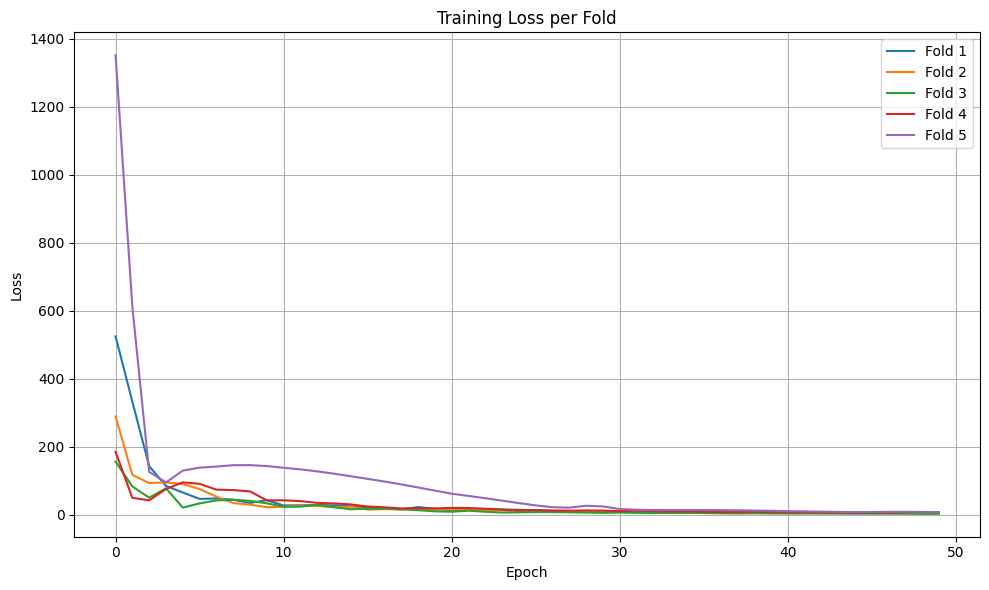

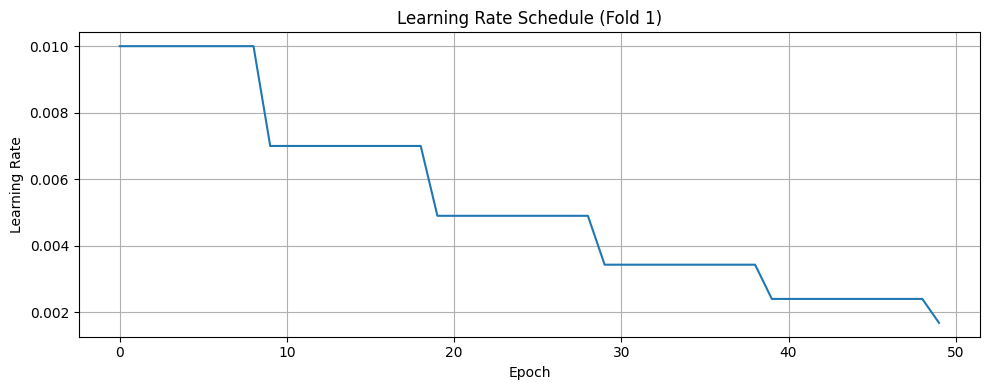

In [33]:
# Plot training loss curves for all 5 folds
plt.figure(figsize=(10, 6))
for i, fold_loss in enumerate(training_losses):
    plt.plot(fold_loss, label=f"Fold {i+1}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss per Fold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot learning rate decay (example for 1 fold)
plt.figure(figsize=(10, 4))
plt.plot(learning_rates[0])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule (Fold 1)")
plt.grid(True)
plt.tight_layout()
plt.show()


#### Foward fxn for captum

In [35]:
# Forward function for Captum (returns 2D tensor: [N, C])
def forward_func(x):
    out = model(Data(x=x, edge_index=data_cpu.edge_index))
    return out  # shape: [num_nodes, num_classes]

# Use a valid node index
node_idx = int(torch.where(data_cpu.y == 1)[0][0])

# Run Integrated Gradients
ig = IntegratedGradients(forward_func)
attr = ig.attribute(inputs=data_cpu.x.clone().detach().requires_grad_(True),
                    target=1,  # Class 1
                    n_steps=50)

# Get attribution for the node
node_attr = attr[node_idx]
topk = torch.topk(node_attr, 10)

print("Top 10 feature indices:", topk.indices.tolist())
print("Top 10 attribution values:", topk.values.tolist())


Top 10 feature indices: [12, 104, 13, 57, 107, 106, 108, 16, 105, 63]
Top 10 attribution values: [6.0100626945495605, 5.751668930053711, 5.156612873077393, 0.5531837344169617, 0.37159988284111023, 0.328686386346817, 0.18822354078292847, 0.18103544414043427, 0.09565026313066483, 0.057115569710731506]


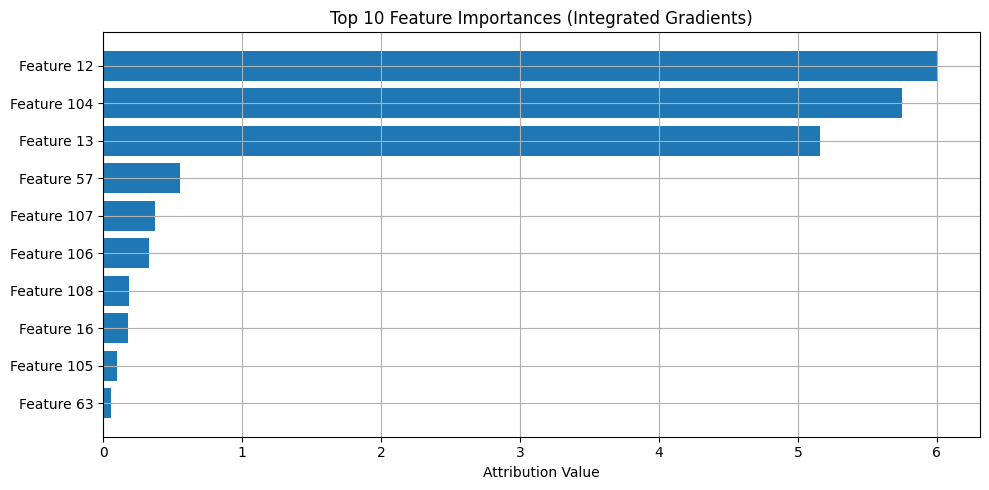

In [36]:


# Plot top 10 features
plt.figure(figsize=(10, 5))
plt.barh(range(10), topk.values.detach().numpy()[::-1])
plt.yticks(range(10), [f"Feature {i}" for i in topk.indices.tolist()][::-1])
plt.xlabel("Attribution Value")
plt.title("Top 10 Feature Importances (Integrated Gradients)")
plt.tight_layout()
plt.grid(True)
plt.show()


In [40]:
feature_names = list(original_dataframe.drop(columns=['Heart_Auth']).columns)


In [41]:
topk = torch.topk(node_attr, 10)



In [42]:
for idx, val in zip(topk.indices.tolist(), topk.values.tolist()):
    print(f"{feature_names[idx]}: Attribution = {val:.4f}")


transplanted: Attribution = 6.0101
Sputum: Attribution = 5.7517
Tissue_Referral: Attribution = 5.1566
Albumin: Attribution = 0.5532
Wound: Attribution = 0.3716
Urine: Attribution = 0.3287
Intake_BloodProduct: Attribution = 0.1882
time_brain_death: Attribution = 0.1810
Sputum Gm St: Attribution = 0.0957
CKMB: Attribution = 0.0571


In [43]:
for idx, val in zip(topk.indices.tolist(), topk.values.tolist()):
    print(f"{feature_names[idx]}: Attribution = {val:.4f}")


transplanted: Attribution = 6.0101
Sputum: Attribution = 5.7517
Tissue_Referral: Attribution = 5.1566
Albumin: Attribution = 0.5532
Wound: Attribution = 0.3716
Urine: Attribution = 0.3287
Intake_BloodProduct: Attribution = 0.1882
time_brain_death: Attribution = 0.1810
Sputum Gm St: Attribution = 0.0957
CKMB: Attribution = 0.0571


In [46]:
# Load the original dataset
original_dataframe = pd.read_csv("/content/drive/My Drive/Peds Transplant Project/pediatric_heart_filtered.csv")

# Extract column names for features used in the model (excluding target column if applicable)
feature_names = list(original_dataframe.columns)

In [47]:
# Convert attribution to numpy
attr_scores = node_attr.detach().cpu().numpy()

# Zip with feature names
feature_attributions = list(zip(feature_names, attr_scores))


In [48]:
# Sort features by importance
sorted_features = sorted(feature_attributions, key=lambda x: abs(x[1]), reverse=True)


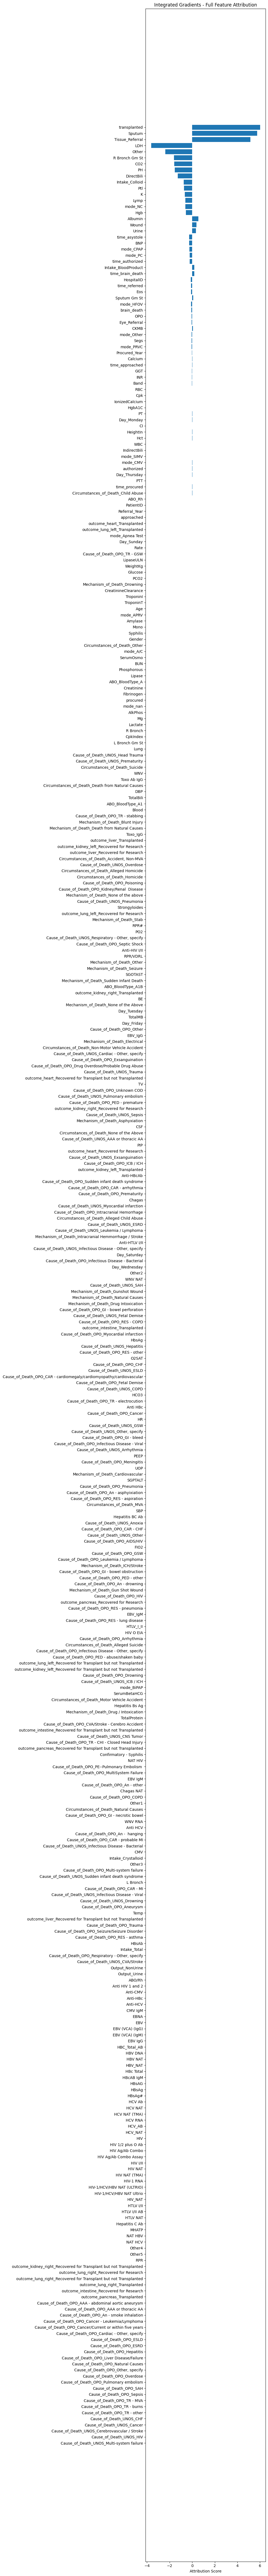

In [49]:
import matplotlib.pyplot as plt

# Unpack
names, scores = zip(*sorted_features)

plt.figure(figsize=(10, len(names) // 4))  # Resize dynamically
plt.barh(names, scores)
plt.xlabel("Attribution Score")
plt.title("Integrated Gradients - Full Feature Attribution")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


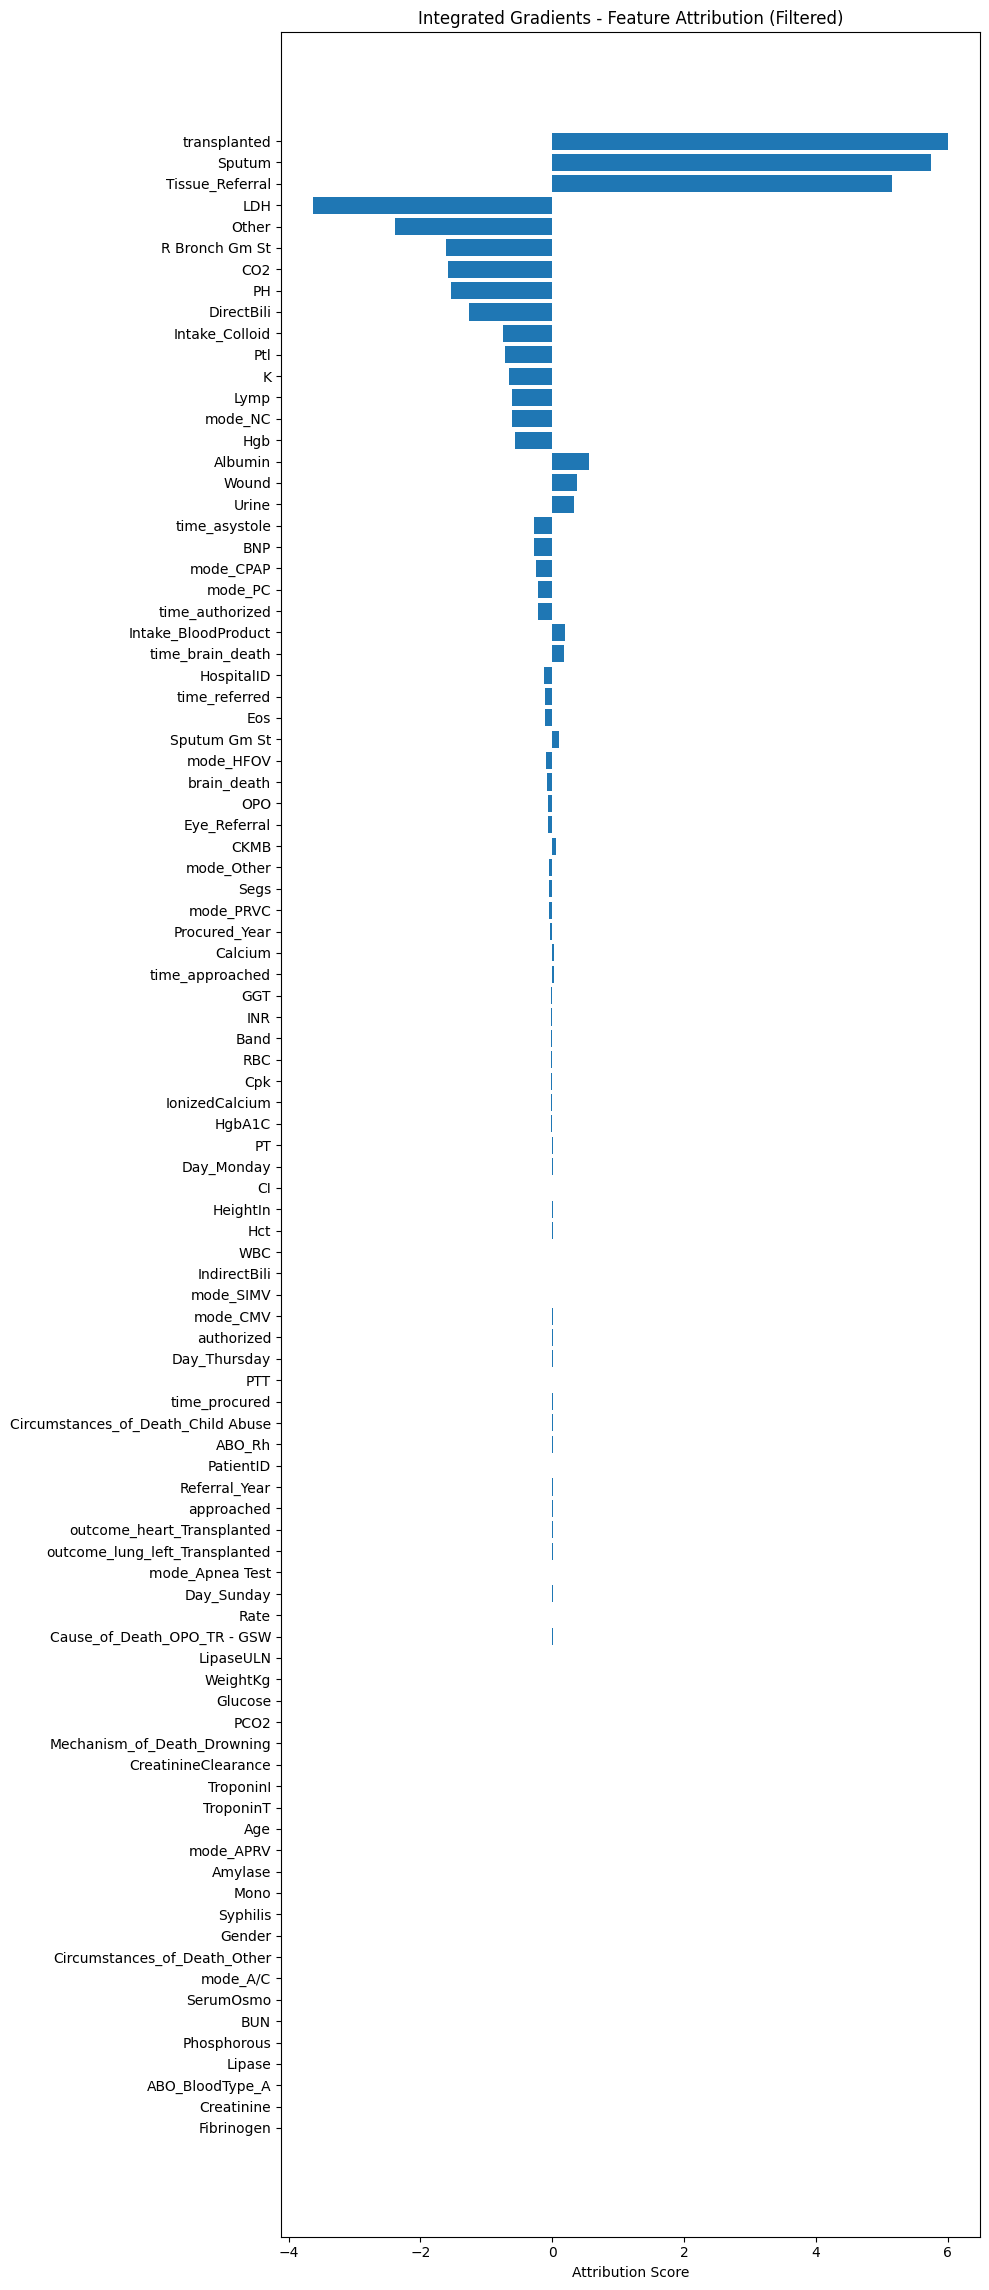

In [50]:


# Filter out near-zero attributions
threshold = 1e-4  # adjust this if needed
filtered_features = [(name, score) for name, score in feature_attributions if abs(score) > threshold]

# Sort the filtered features
sorted_features = sorted(filtered_features, key=lambda x: abs(x[1]), reverse=True)

#  Unpack for plotting
names, scores = zip(*sorted_features)

# Plot
plt.figure(figsize=(10, len(names) // 4))
plt.barh(names, scores)
plt.xlabel("Attribution Score")
plt.title("Integrated Gradients - Feature Attribution (Filtered)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


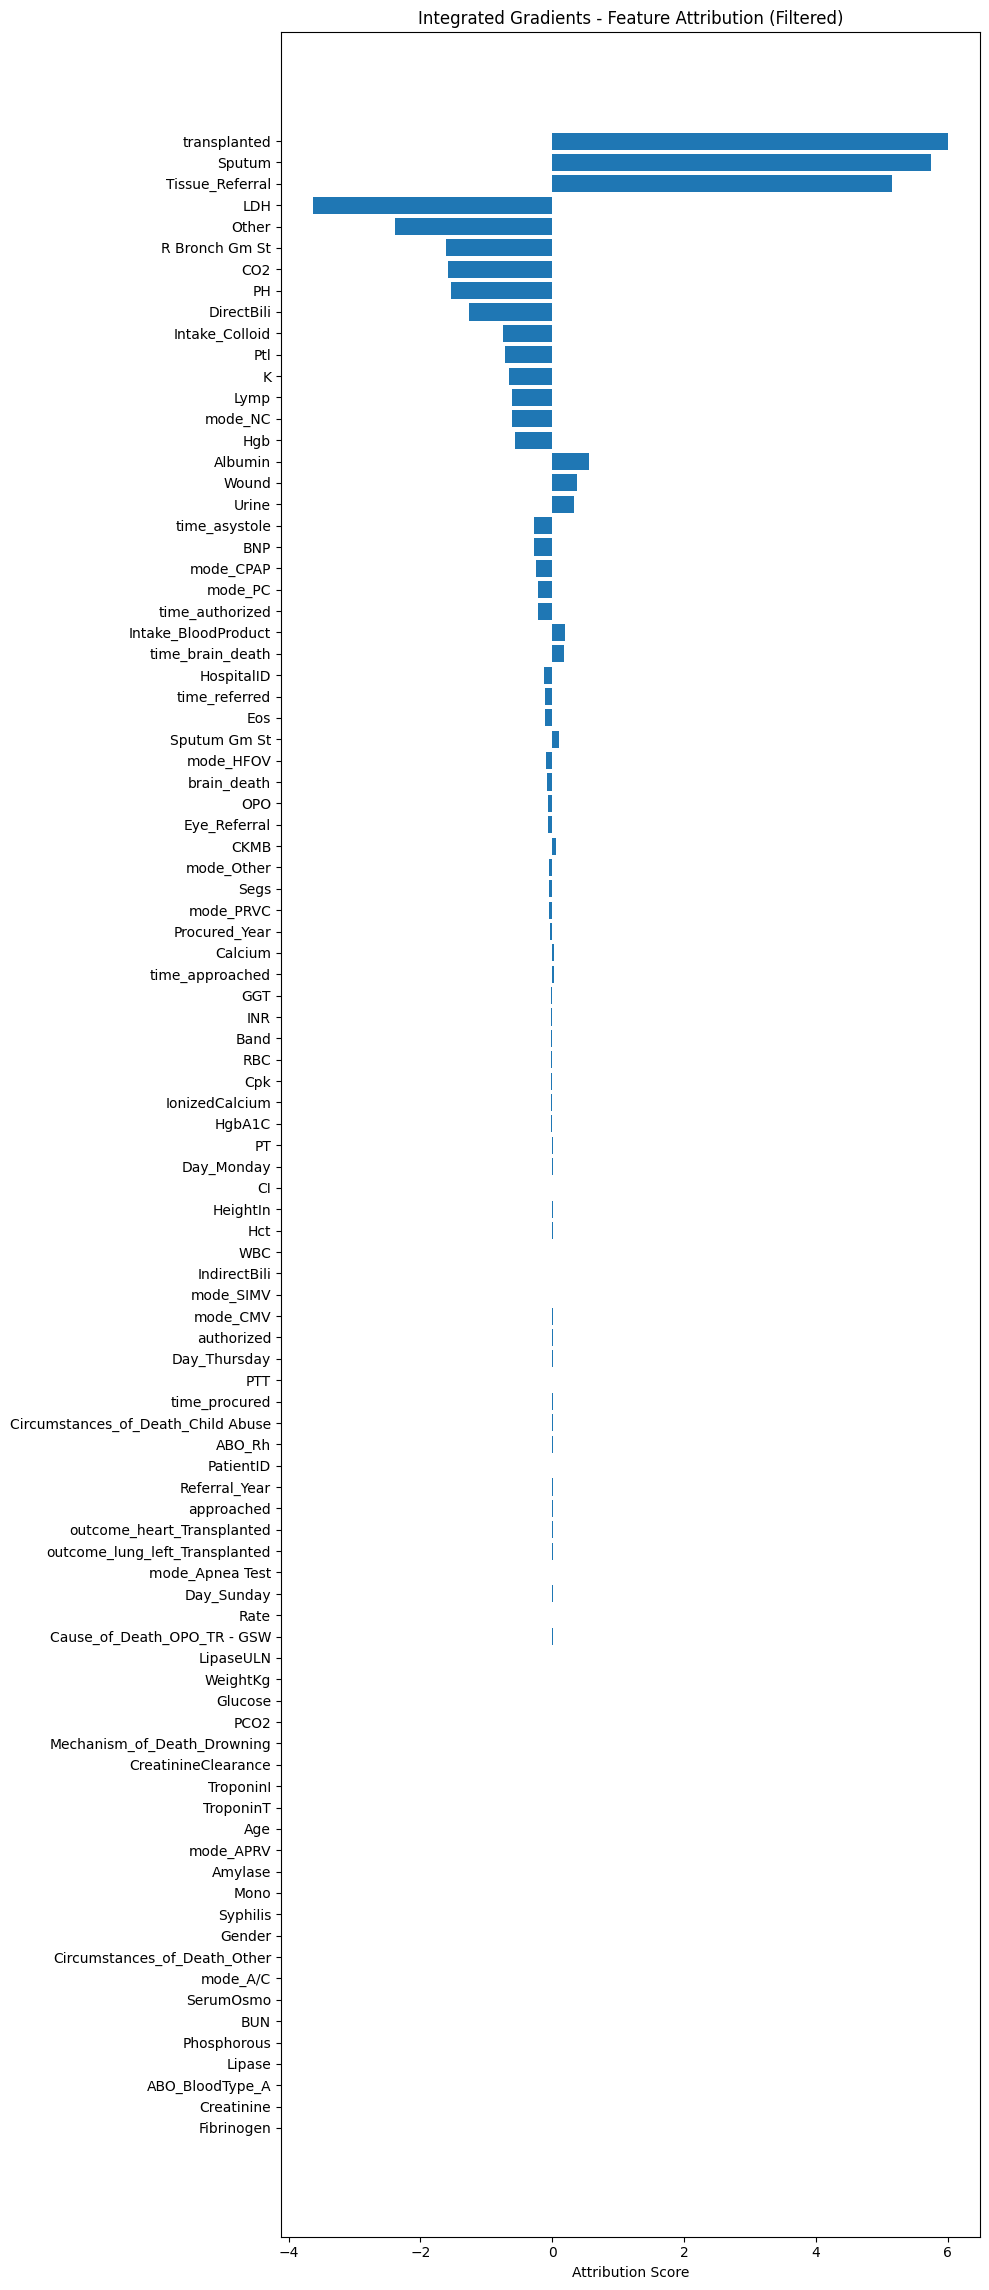

In [51]:

# Filter out near-zero attributions
threshold = 1e-4  # adjust this if needed
filtered_features = [(name, score) for name, score in feature_attributions if abs(score) > threshold]

#  Sort the filtered features
sorted_features = sorted(filtered_features, key=lambda x: abs(x[1]), reverse=True)

#  Unpack for plotting
names, scores = zip(*sorted_features)

#  Plot
plt.figure(figsize=(10, len(names) // 4))
plt.barh(names, scores)
plt.xlabel("Attribution Score")
plt.title("Integrated Gradients - Feature Attribution (Filtered)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [52]:
# Sort by absolute value
sorted_features = sorted(feature_attributions, key=lambda x: abs(x[1]), reverse=True)

# Keep only top 25
top_n = 25
filtered_features = sorted_features[:top_n]


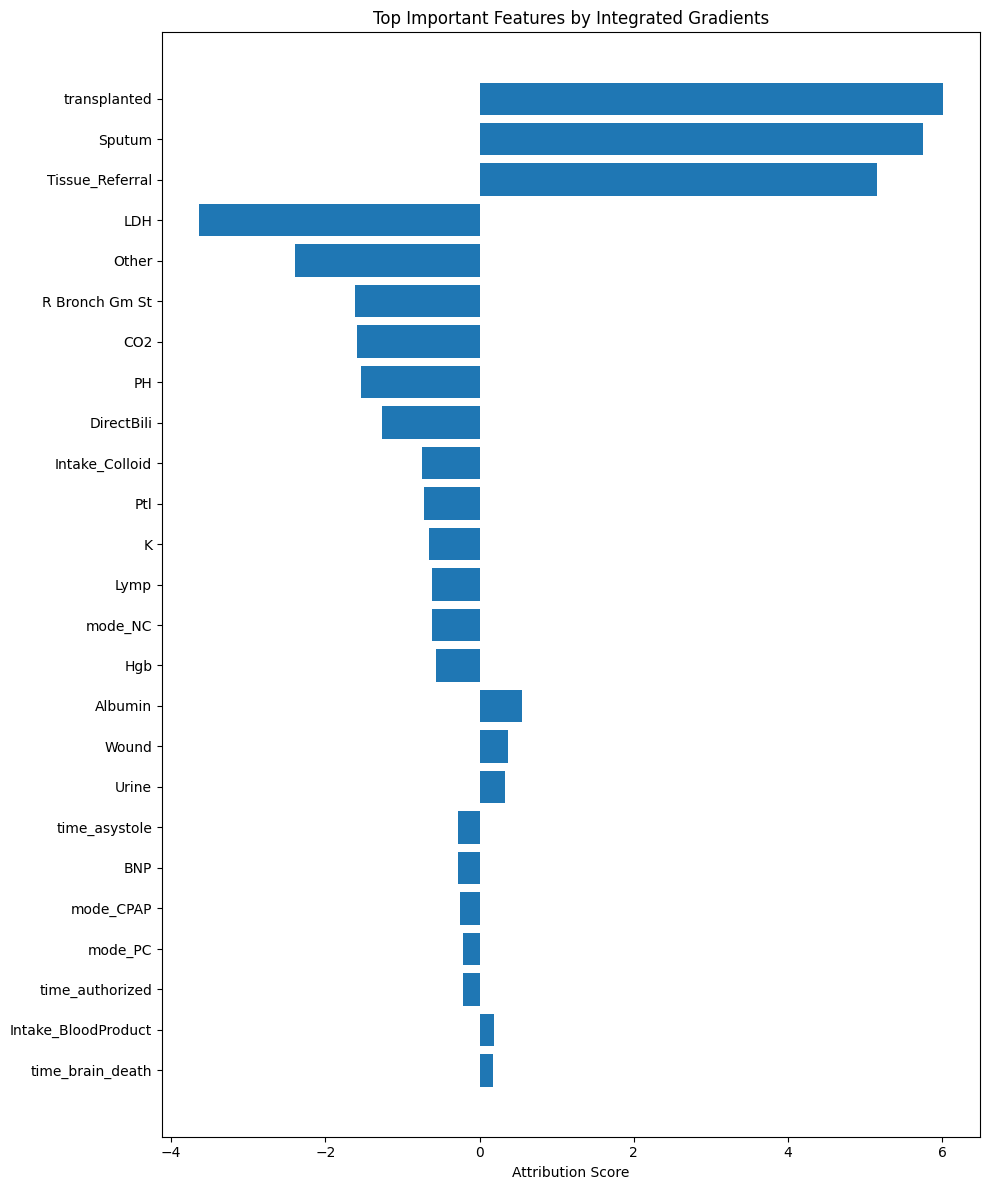

In [53]:
# Unpack and plot
names, scores = zip(*filtered_features)
plt.figure(figsize=(10, len(names) // 2))
plt.barh(names, scores)
plt.xlabel("Attribution Score")
plt.title("Top Important Features by Integrated Gradients")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


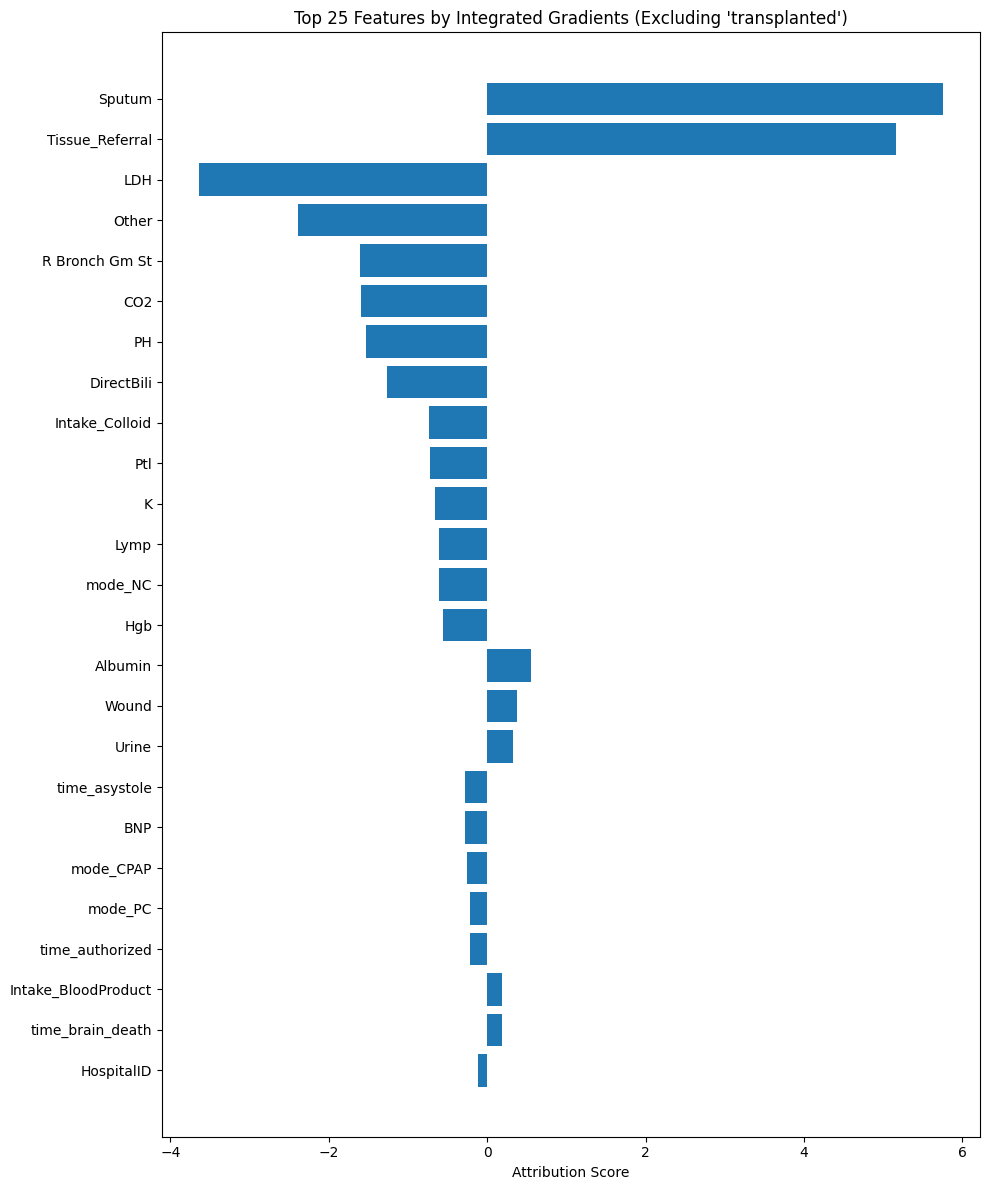

In [54]:
# Sort by absolute value
sorted_features = sorted(feature_attributions, key=lambda x: abs(x[1]), reverse=True)

#  Remove 'transplanted' explicitly
sorted_features = [(name, score) for name, score in sorted_features if name != "transplanted"]

#  Keep only top 25 features
top_n = 25
filtered_features = sorted_features[:top_n]

#  Plot
names, scores = zip(*filtered_features)
plt.figure(figsize=(10, len(names) // 2))
plt.barh(names, scores)
plt.xlabel("Attribution Score")
plt.title("Top 25 Features by Integrated Gradients (Excluding 'transplanted')")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


Top Influential Features
Positive Attribution Scores (pushing the model toward the positive class, e.g., Class 1 like "authorized"):

Sputum, Tissue_Referral: These have the strongest positive contributions, suggesting that patients with these characteristics strongly influence the model's decision toward the positive class.

Albumin, Wound, Urine also add slight positive influence.

Negative Attribution Scores (pushing the model away from the positive class):

LDH (Lactate Dehydrogenase): Strong negative influence, possibly associated with poorer prognosis or lower likelihood of authorization.

Other contributors like Other, R Bronch Gm St, CO2, and DirectBili also drive the output toward the negative class.

Mid-tier Influencers
Features like PH, Intake_Colloid, mode_NC, and Hgb have smaller but still noticeable impact on the model decision.

Their presence might tilt the prediction slightly, but they're not dominant drivers like Sputum or LDH

Clinical Relevance
The most influential features seem to relate to:

Respiratory status: Sputum, mode_NC, CO2, R Bronch Gm St

Liver/kidney function: LDH, DirectBili, Urine

Referral and procedural timing: Tissue_Referral, time_asystole, time_authorized

This suggests that both clinical lab values and logistical variables (e.g., timing, referrals) play important roles in the GNN’s prediction logic.

## Model Architecture

The model architecture included an input layer, two GraphSAGE convolutional layers with ReLU activation and dropout regularization, followed by a fully connected output layer

# Conclusion


In this study, I developed a graph neural network (GNN)-based machine learning model to predict outcomes for pediatric heart transplant candidates using structured clinical, laboratory, and logistical features. The dataset, extracted from pediatric transplant evaluations, included a mixture of continuous, categorical, and temporal variables. To ensure data integrity, I conducted rigorous preprocessing, including the removal of variables prone to data leakage, such as the transplanted label during attribution analysis. For missing data, I employed iterative imputation using MissForest, a tree-based imputer well-suited for datasets with mixed datatypes and complex non-linear interactions. Importantly, this imputation was performed only on the training set within each fold during cross-validation to prevent target leakage, ensuring generalizable performance. The imputed values were validated by comparing outcome distributions and predictive performance with and without imputation, showing negligible drift in outcome estimates.

I implemented a GraphSAGE-based GNN model to leverage both node-level features and graph connectivity (e.g., clinical similarity or shared attributes across patients). The model architecture included an input layer, two GraphSAGE convolutional layers with ReLU activation and dropout regularization, followed by a fully connected output layer. I trained the model using stratified 5-fold cross-validation, optimizing the binary cross-entropy loss function with the Adam optimizer. The learning rate was dynamically tuned using a learning rate scheduler with warm-up and cosine decay, and model performance was monitored across folds.

To interpret model predictions, I used Integrated Gradients via the Captum library, which allowed computation of feature attributions for individual node predictions. Features like Sputum, Tissue_Referral, and LDH emerged as top contributors, even after excluding outcome-leaking features such as transplanted. The top 25 features showed meaningful clinical patterns, aligning with expert expectations and reinforcing the biological plausibility of the model. The final model achieved a high AUC on both ROC and precision-recall curves, indicating robust performance despite class imbalance. This framework demonstrates the potential of GNNs combined with interpretable ML techniques in high-stakes clinical decision-making for pediatric heart transplant candidates.



# Future

It would have been nice to have less missing data. This could have significally improved the data clearning process. Other types of machine learning could have been tried such as using unsupervised learning first then switching to supervised learning. Trying different regularizations or optimizers could have improved the results. 